# Head Trained Denoiser Tested on Pediatric Abdomen: Demonstrating Protocol More Significant than Anatomy

The goal of this study is to train a denoising model on a Low Dose Head CT training dataset and test on a low dose abdomen CT dataset.

This will address the feedback from Reviewer 1 and the AE of whether the difference in pediatric performance is due to anatomic differences or acquisition differences. 

The hypothesis of this experiment is that the head trained denoising model will perform as well as the small-FOV abdomen model (the pediatric protocol).

This supports our method of FOV/texture based augmentation over training more burdensome dedicated pediatric models. If it doesn’t test as well on the abdomen test set that will suggest it’s a mix of both acquisition and anatomic differences.

## Low Dose Head CT Dataset

Generated from `bash make_heads_dataset.sh`

Using [PedSilicoICH](https://github.com/DIDSR/PedSilicoICH)

In [1]:
from torchvision.transforms import v2
import torch

import sys
sys.path.append('../head_denoising')

from data import  LDHeadCTDataset

base_dir = '/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/head_experiment'
tfms = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=False)])
dset = LDHeadCTDataset(base_dir, transform=tfms, target_transform=tfms, train=False)
dset

Dataset LDHeadCTDataset
    Number of datapoints: 161
    Root location: /projects01/didsr-aiml/brandon.nelson/pedsilicoICH/head_experiment

/tmp/ipykernel_3310955/4272711026.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ctshow(np.array(x), fig=f, ax=axs[0], window=window)
/tmp/ipykernel_3310955/4272711026.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  ctshow(np.array(y), fig=f, ax=axs[1], window=window)


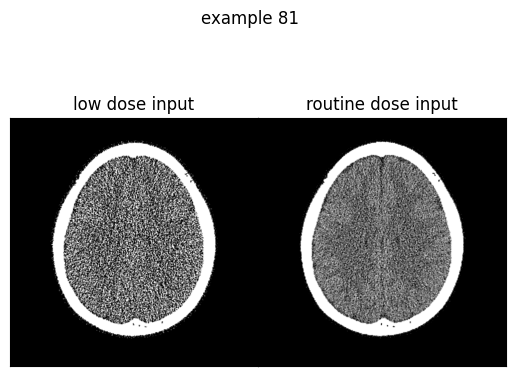

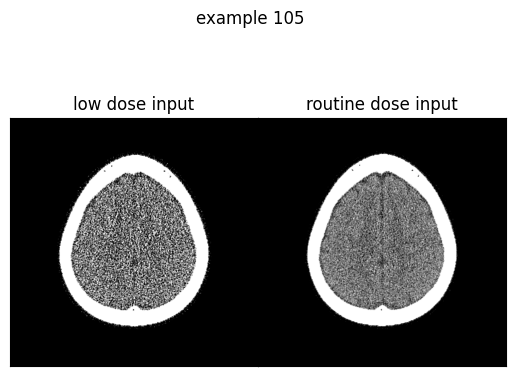

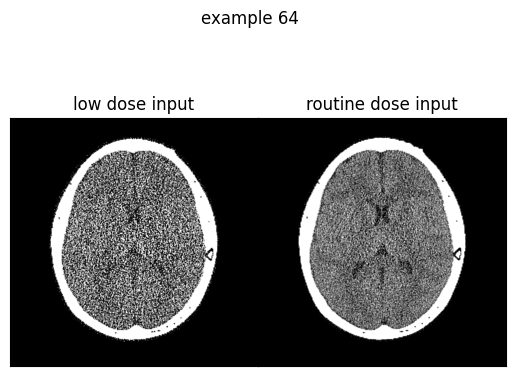

In [2]:
from utils import ctshow
import numpy as np
import matplotlib.pyplot as plt

n_examples = 10
random = np.random.default_rng(43)

count = 0
while count < 3:
    idx = random.integers(0, len(dset))
    x, y = dset[idx]

    # if x.mean() < -300:
    #     continue
    window = 'brain'
    f, axs = plt.subplots(1, 2, gridspec_kw=dict(hspace=0,wspace=0))
    f.suptitle(f'example {idx}')
    ctshow(np.array(x), fig=f, ax=axs[0], window=window)
    axs[0].set_title('low dose input')
    ctshow(np.array(y), fig=f, ax=axs[1], window=window)
    axs[1].set_title('routine dose input')
    count += 1
    f.show()
    

Now make a datamodule

In [3]:
import lightning as L
from networks import UNet, LitAutoEncoder
redcnn = LitAutoEncoder.load_from_checkpoint('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/version_6055226/checkpoints/epoch=78-step=30968.ckpt')
unet = UNet.load_from_checkpoint('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/version_6072378/checkpoints/epoch=99-step=39200.ckpt')
trainer = L.Trainer()

/home/brandon.nelson/anaconda3/envs/noise_augmentation/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/brandon.nelson/anaconda3/envs/noise_augmentati ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

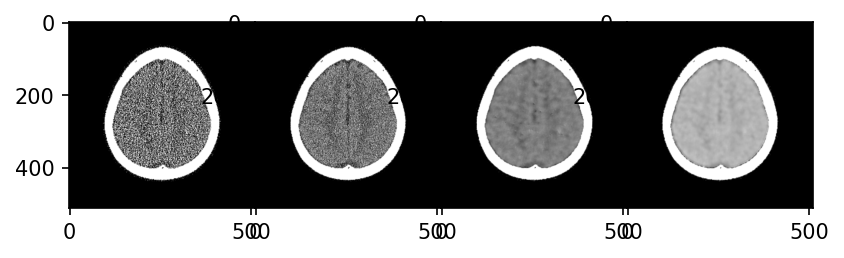

In [4]:
idx = 100
x, y = dset[idx]
red_pred = trainer.predict(dataloaders=x[None, None], model=redcnn)
unet_pred = trainer.predict(dataloaders=x[None, None], model=unet)

f, axs = plt.subplots(1, 4, dpi=150, gridspec_kw=dict(wspace=0, hspace=0))
ww, wl = 80, 40

display=dict(
    cmap='gray',
    vmin = wl - ww/2,
    vmax = wl + ww/2
)

axs[0].imshow(x.squeeze(), **display)
axs[1].imshow(y.squeeze(), **display)
axs[2].imshow(red_pred[0].squeeze(), **display)
axs[3].imshow(unet_pred[0].squeeze(), **display)

In [9]:
checkpoints = [
    '/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/version_6071367/checkpoints/epoch=99-step=39200.ckpt',
    '/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/version_6072378/checkpoints/epoch=99-step=39200.ckpt',
    '/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/head_denoising/lightning_logs/version_6073387/checkpoints/epoch=99-step=39200.ckpt'
]

unets = [UNet.load_from_checkpoint(o) for o in checkpoints]

preds = []

for model in unets:
    preds.append(trainer.predict(dataloaders=x[None, None], model=model))
preds = np.stack(preds).squeeze()
preds

/home/brandon.nelson/anaconda3/envs/noise_augmentation/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/brandon.nelson/anaconda3/envs/noise_augmentati ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[[-968.6114 , -979.88214, -974.77295, ..., -974.34155,
         -976.8153 , -967.9335 ],
        [-971.6922 , -974.5562 , -976.3634 , ..., -980.7198 ,
         -982.5948 , -981.3507 ],
        [-972.17285, -973.8572 , -975.8538 , ..., -979.2901 ,
         -982.0377 , -979.4434 ],
        ...,
        [-973.7823 , -973.9766 , -980.5361 , ..., -972.0985 ,
         -975.1818 , -975.6073 ],
        [-972.86255, -975.89124, -978.30884, ..., -973.1763 ,
         -978.2669 , -977.89386],
        [-963.87   , -973.3135 , -974.795  , ..., -968.7335 ,
         -968.0121 , -960.61176]],

       [[-976.693  , -986.17584, -987.09717, ..., -978.1924 ,
         -978.1107 , -978.3696 ],
        [-982.0508 , -981.0231 , -990.23926, ..., -983.14545,
         -979.9547 , -984.00433],
        [-987.70026, -987.324  , -994.7237 , ..., -981.2744 ,
         -982.0435 , -983.6478 ],
        ...,
        [-993.83844, -989.8153 , -993.8361 , ..., -983.429  ,
         -981.9752 , -975.6076 ],
        [-98

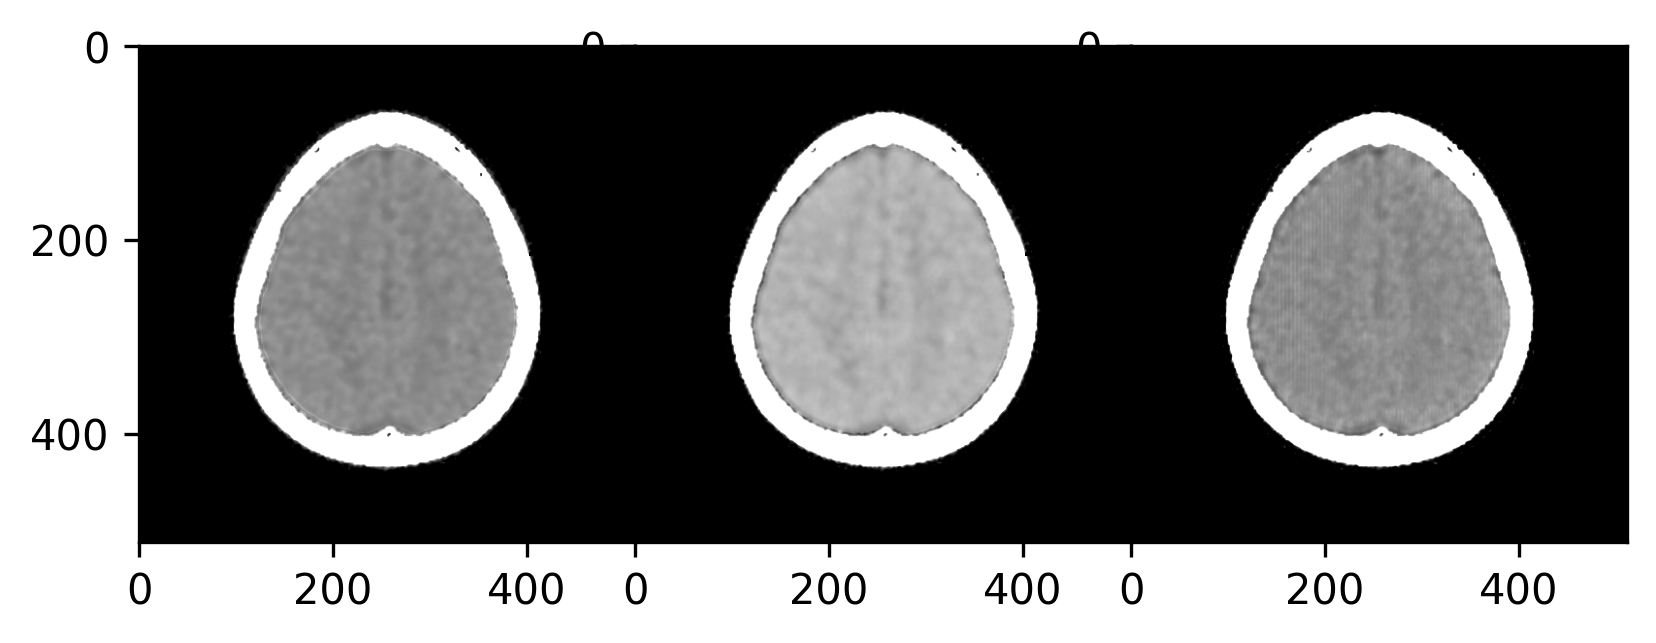

In [14]:
f, axs = plt.subplots(1, 3, dpi=300, gridspec_kw=dict(wspace=0, hspace=0))
ww, wl = 80, 40

display=dict(
    cmap='gray',
    vmin = wl - ww/2,
    vmax = wl + ww/2
)

for p, ax in zip(preds, axs):
    ax.imshow(p, **display)

In [ ]:
from torch.nn.functional import mse_loss
p.shape

(512, 512)

3

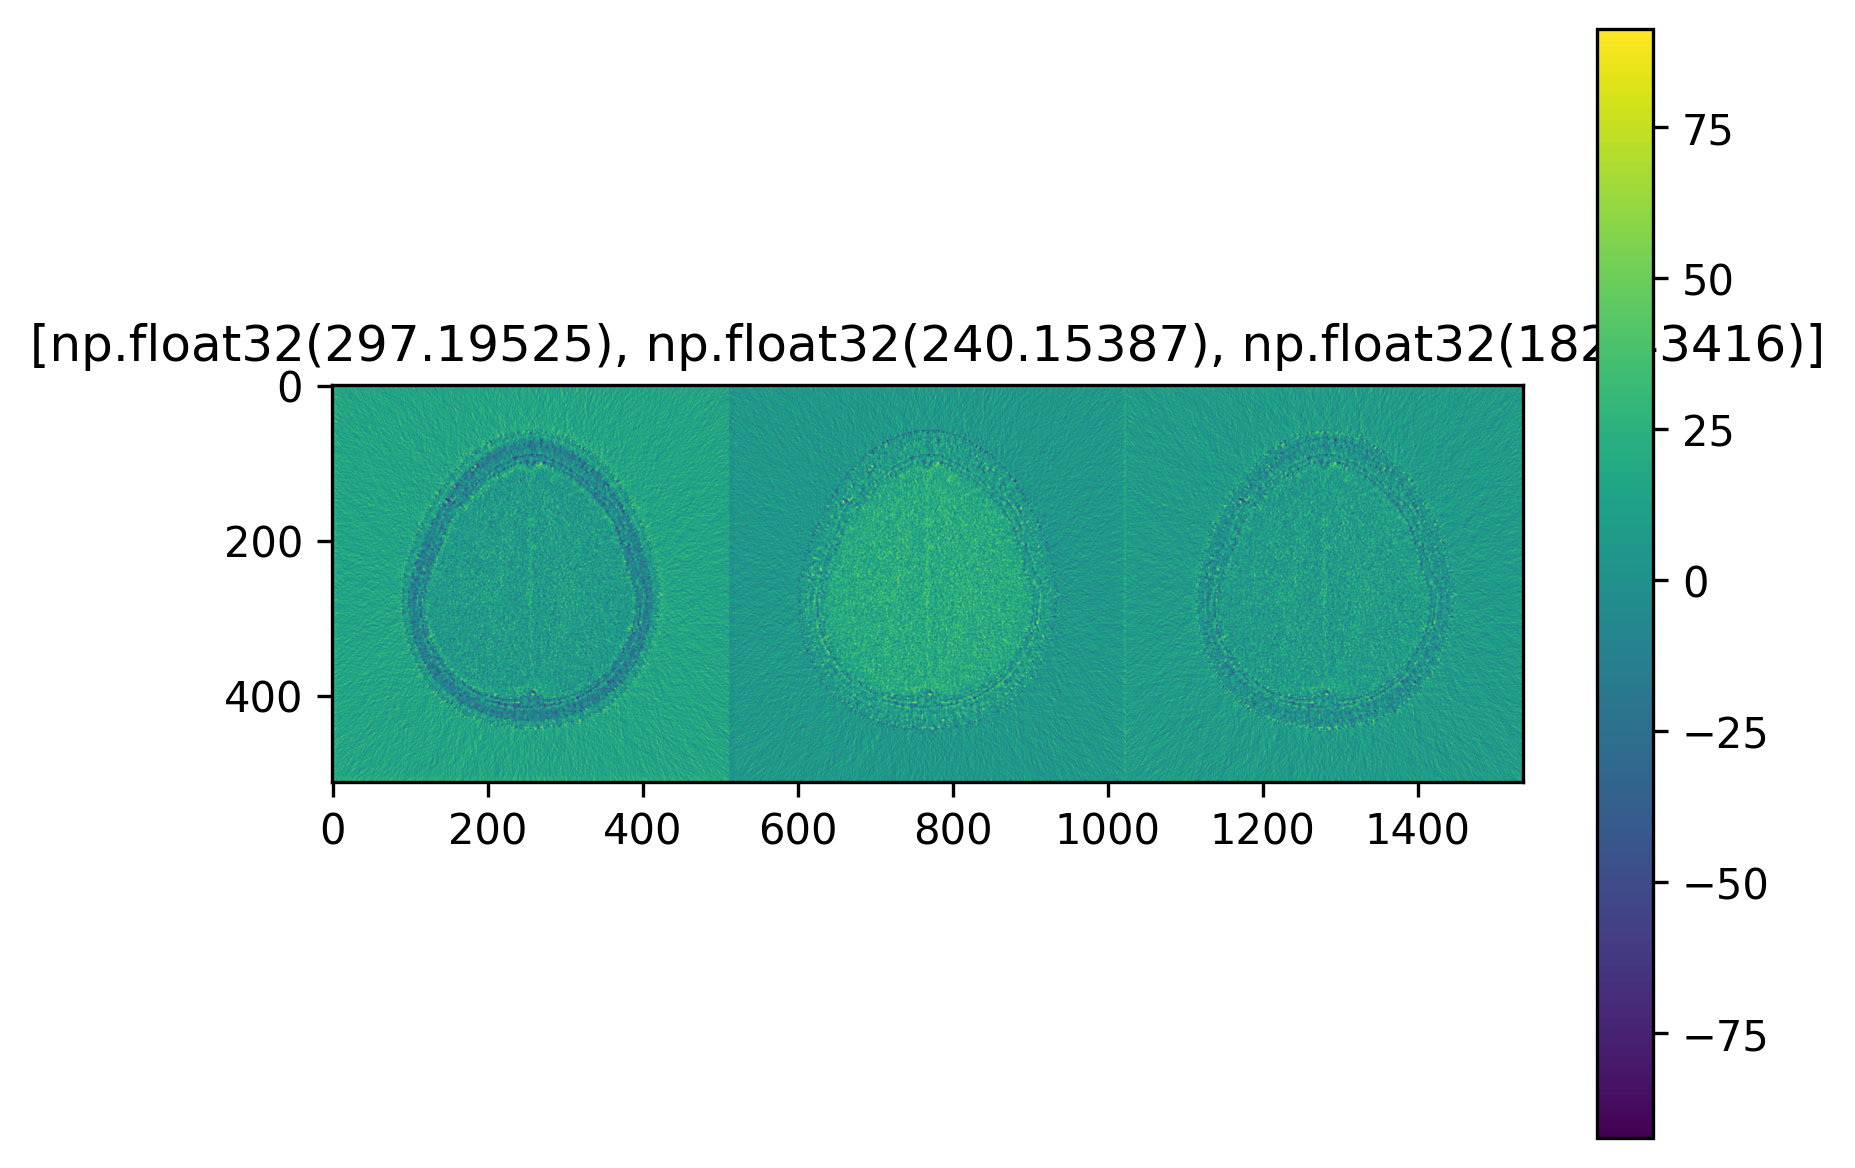

In [41]:
f, axs = plt.subplots(1, 1, dpi=300, gridspec_kw=dict(wspace=0, hspace=0))
ww, wl = 80, 40

display=dict(
    cmap='gray',
    vmin = wl - ww/2,
    vmax = wl + ww/2
)

def mse(a, b): return np.mean((a-b)**2)
mses = [mse(o.ravel(), y.numpy().ravel()) for o in preds]
im = axs.imshow(np.concat(preds-y.squeeze().numpy(), axis=1))
axs.set_title(mses)
plt.colorbar(im)

In [ ]:
dm.setup('predict')
for x, y in dm.predict_dataloader():
    break

In [ ]:
x.shape, y.shape

In [ ]:
dm = LDHeadCTDataModule(base_dir, num_workers=5)
model = LitAutoEncoder.load_from_checkpoint('/home/brandon.nelson/Dev/pediatric-CT-noise-texture-augmentation/notebooks/lightning_logs/version_3/checkpoints/epoch=99-step=39200.ckpt', torch_module=RED_CNN())
trainer = L.Trainer()
out = trainer.predict(model=model, datamodule=dm)


In [ ]:
model.eval()

In [ ]:
out = trainer.predict(model, x)

In [ ]:
out[0].shape, x.shape

In [ ]:
f, axs = plt.subplots()
im = ctshow(np.array(out[-1][0]), window='brain')
plt.colorbar(im)